In [ ]:
### For demoing, you can set the following values and then delete this cell
import os
os.environ["BIGTABLE_PROJECT_ID"] = "PROJECT_ID"
os.environ["BIGTABLE_INSTANCE_ID"] = "INSTANCE_ID"
os.environ["BIGTABLE_TABLE_ID"] = "TABLE_ID"
os.environ["GOOGLE_API_KEY"] = "API_KEY"

# Data Dash

In this notebook, we will ingest data about car races from Bigtable and analyze it with various Spark tools.

## Connect to Bigtable and Spark

First, we create our Spark connection and include the Bigtable Spark connector jar.

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import os

spark = (SparkSession.builder
         .config('spark.jars', "gs://spark-lib/bigtable/spark-bigtable_2.12-0.1.1.jar")
         .getOrCreate())

bigtable_project_id = os.environ["BIGTABLE_PROJECT_ID"]
bigtable_instance_id = os.environ["BIGTABLE_INSTANCE_ID"]
bigtable_table_name = os.environ["BIGTABLE_TABLE_ID"]

# Manually indicating columns from Bigtable for Spark dataframe.
catalog = ''.join(("""{
      "table":{"namespace":"default", "name":" """ + bigtable_table_name + """
       ", "tableCoder":"PrimitiveType"},
      "rowkey":"rowkey",
      "columns":{
        "_rowkey":{"cf":"rowkey", "col":"rowkey", "type":"string"},
        "Car_ID":{"cf":"cf", "col":"car_id", "type":"string"},
        "Start":{"cf":"cf", "col":"t1_s", "type":"string"},
        "End":{"cf":"cf", "col":"t8_e", "type":"string"},
        "Checkpoint_1":{"cf":"cf", "col":"t1_s", "type":"string"},
        "Checkpoint_2":{"cf":"cf", "col":"t2_s", "type":"string"},
        "Checkpoint_3":{"cf":"cf", "col":"t3_s", "type":"string"},
        "Checkpoint_4":{"cf":"cf", "col":"t4_s", "type":"string"},
        "Checkpoint_5":{"cf":"cf", "col":"t5_s", "type":"string"},
        "Checkpoint_6":{"cf":"cf", "col":"t6_s", "type":"string"},
        "Checkpoint_7":{"cf":"cf", "col":"t7_s", "type":"string"},
        "Checkpoint_8":{"cf":"cf", "col":"t8_s", "type":"string"},
        "Checkpoint_1_end":{"cf":"cf", "col":"t1_e", "type":"string"},
        "Checkpoint_2_end":{"cf":"cf", "col":"t2_e", "type":"string"},
        "Checkpoint_3_end":{"cf":"cf", "col":"t3_e", "type":"string"},
        "Checkpoint_4_end":{"cf":"cf", "col":"t4_e", "type":"string"},
        "Checkpoint_5_end":{"cf":"cf", "col":"t5_e", "type":"string"},
        "Checkpoint_6_end":{"cf":"cf", "col":"t6_e", "type":"string"},
        "Checkpoint_7_end":{"cf":"cf", "col":"t7_e", "type":"string"},
        "Checkpoint_8_end":{"cf":"cf", "col":"t8_e", "type":"string"}
      }
      }""").split())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/25 00:25:58 INFO SparkEnv: Registering MapOutputTracker
24/06/25 00:25:58 INFO SparkEnv: Registering BlockManagerMaster
24/06/25 00:25:58 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/06/25 00:25:58 INFO SparkEnv: Registering OutputCommitCoordinator


## Reading the raw data

Here we will read from our Bigtable table and create and display a dataframe with the data.

In [3]:
df = spark.read \
  .format('bigtable') \
  .option('spark.bigtable.project.id', bigtable_project_id) \
  .option('spark.bigtable.instance.id', bigtable_instance_id) \
  .options(catalog=catalog) \
  .load()

print('Reading the DataFrame from Bigtable:')
df.show()

Reading the DataFrame from Bigtable:


+------------------+------------------+------------------+------------------+------------------+------------------+------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+
|  Checkpoint_6_end|      Checkpoint_7|      Checkpoint_1|      Checkpoint_4|  Checkpoint_3_end|  Checkpoint_7_end|      Car_ID|      Checkpoint_3|      Checkpoint_6|  Checkpoint_4_end|             Start|  Checkpoint_8_end|               End|      Checkpoint_8|             _rowkey|  Checkpoint_1_end|      Checkpoint_2|      Checkpoint_5|  Checkpoint_5_end|  Checkpoint_2_end|
+------------------+------------------+------------------+------------------+------------------+------------------+------------+------------------+------------------+------------------+------------------+------------------+------------------+--

## Extracting value with Spark SQL

Spark SQL gives us a SQL layer we can use on top of our data. 

>Note that for large Bigtable datasets, you will want to do some filtering on rowkey to ensure a performant query.

### Query the total times for each race

In [4]:
df.createOrReplaceTempView("races")

total_times = spark.sql("""
    SELECT 
        _rowkey,
        car_id,
        bround((end - start), 2) as duration_in_secs 
    FROM 
        races
""")
total_times.show()

+--------------------+------------+----------------+
|             _rowkey|      car_id|duration_in_secs|
+--------------------+------------+----------------+
|track1#8280728985...|584613083274|            7.18|
|track1#8280728986...|584613083274|            7.34|
|track1#8280728986...|584613543557|            7.24|
|track1#8280728986...|584613543557|            7.16|
|track1#8280728987...|584613543557|            7.26|
|track1#8280728987...|584613083274|            7.26|
|track1#8280728990...|584613543557|             7.2|
|track1#8280728990...|584613083274|            7.29|
|track1#8280728991...|584613543557|            7.48|
|track1#8280728992...|584613543557|            7.15|
|track1#8280728993...|584613083274|            7.34|
|track1#8280728994...|584613543557|            7.16|
|track1#8280728994...|584613543557|            7.05|
|track1#8280728995...|584613083274|             7.2|
|track1#8280728997...|584613543557|            7.38|
|track1#8280728998...|584613083274|           

### Query the total time per race and plot the average per car

<AxesSubplot:xlabel='car_id'>

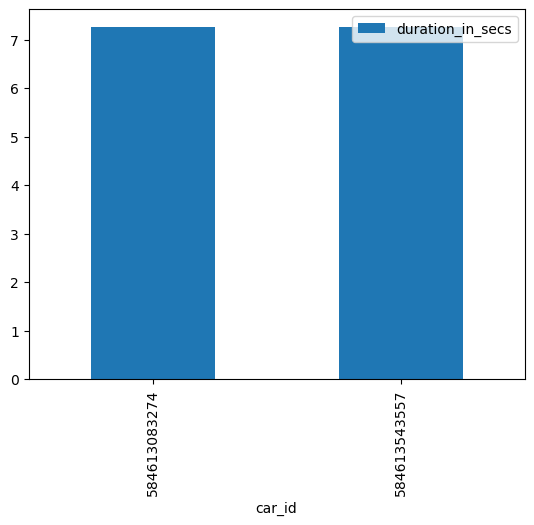

In [5]:
average_per_car = spark.sql("""
    SELECT 
        car_id, 
        bround(avg((end - start)), 2) as duration_in_secs 
    FROM 
        races 
    GROUP BY 
        car_id 
    ORDER BY 
        car_id
""")
average_per_car.toPandas().plot.bar(x='car_id')

### Calculate speed for cars

Using a car length of 2.5 inches, we will find the speed in **miles per hour** at each checkpoint using when the time it entered the checkpoint and the time when it exited it.

We are approxomating the conversion of inches per second to miles per hour as: 1 in/s = 0.0568 mph

+--------------------+------------+--------+--------+--------+--------+--------+--------+--------+--------+
|             _rowkey|      car_id|C1_speed|C2_speed|C3_speed|C4_speed|C5_speed|C6_speed|C7_speed|C8_speed|
+--------------------+------------+--------+--------+--------+--------+--------+--------+--------+--------+
|track1#8280728986...|584613543557| 0.51825| 0.55686|  0.4965| 0.49391| 0.49306| 0.54199| 0.50896|  0.5192|
|track2#8280728983...|584613083274| 0.50896|  0.5269| 0.55039| 0.48797| 0.56238| 0.55577| 0.48714| 0.56687|
+--------------------+------------+--------+--------+--------+--------+--------+--------+--------+--------+



<AxesSubplot:xlabel='car_id'>

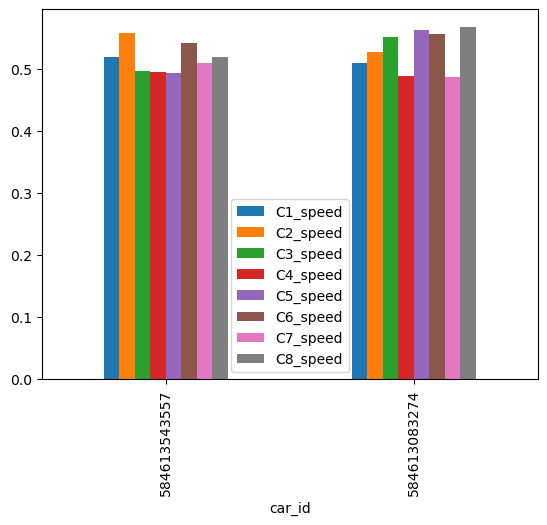

In [6]:
speeds = spark.sql("""
    SELECT 
        _rowkey, 
        car_id,
        bround(.0568*2.5/((Checkpoint_1_end - Checkpoint_1)), 5) as C1_speed,
        bround(.0568*2.5/((Checkpoint_2_end - Checkpoint_2)), 5) as C2_speed,
        bround(.0568*2.5/((Checkpoint_3_end - Checkpoint_3)), 5) as C3_speed,
        bround(.0568*2.5/((Checkpoint_4_end - Checkpoint_4)), 5) as C4_speed,
        bround(.0568*2.5/((Checkpoint_5_end - Checkpoint_5)), 5) as C5_speed,
        bround(.0568*2.5/((Checkpoint_6_end - Checkpoint_6)), 5) as C6_speed,
        bround(.0568*2.5/((Checkpoint_7_end - Checkpoint_7)), 5) as C7_speed,
        bround(.0568*2.5/((Checkpoint_8_end - Checkpoint_8)), 5) as C8_speed
    FROM 
        races 
    ORDER BY start DESC 
    LIMIT 2
""")

speeds.show()
speeds.toPandas().plot.bar(x="car_id")

### Helper functions for graphing races

Now we can perform some math on each of the races and graph each one to see the results. We'll define a few helper functions here.

In [19]:
import pandas as pd
from IPython import display
import time

def graph_races(races, key="_rowkey", legend=True):
    races_with_diffs = races.alias("races_with_diffs")
    # Find the diffs for each checkpoint
    checkpoint_cols = [col for col in races.columns if col.startswith('Checkpoint_')]
    for checkpoint in checkpoint_cols:
        races_with_diffs = races_with_diffs.withColumn(
        f"{checkpoint}_diff", 
        (col(checkpoint) - col("Start")))
    
    # Create a new data structure to use the diffs
    data = {}
    checkpoint_diff_cols = [f"Checkpoint_{i}_diff" for i in range(1,9)]
    for row in races_with_diffs.collect():
        data[row[key]] = [row[col] for col in checkpoint_diff_cols]
    
    race_data = pd.DataFrame(data, index=range(1,9))
    race_data.plot.line(xlabel="Checkpoint", ylabel="Time (seconds)", legend=legend)
    return race_data
    
def graph_races_by_car(races):
    graph_races(races, key="Car_ID", legend=True)

### Graph the two most recent races against each other

,track1#8280730074.084286,track1#8280730048.516078
1,0.0000,0.0000
2,1.0675,0.9550
3,2.1800,1.9825
4,3.1975,2.9850
5,4.0475,4.1100
6,4.9675,5.1050
7,6.1175,6.0600
8,7.0675,7.0225


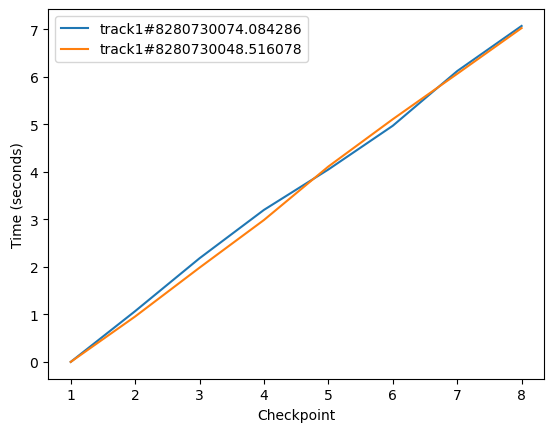

In [23]:
races = spark.sql("""
    SELECT 
        *, 
        FROM_UNIXTIME(start) 
    FROM 
        races
    ORDER BY start
    LIMIT 2
""")

graph_races(races)

### Query the most recent race for each car and order them by total time

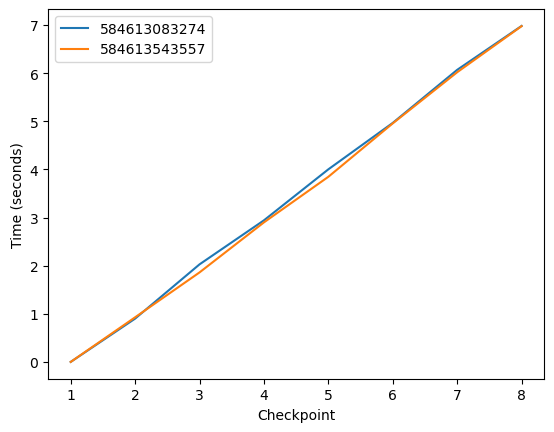

In [24]:
recent_races = spark.sql("""
    SELECT
        * 
    FROM 
        races
    WHERE (_rowkey, car_id) IN (
        SELECT 
           MAX(_rowkey), 
           car_id
        FROM
            races
        GROUP BY car_id
    )
""")


graph_races_by_car(recent_races)

### Graph all the races for one car

,track1#8280728986.137873,track1#8280728986.509577,track1#8280728987.389035,track1#8280728990.298508,track1#8280728991.744606,track1#8280728992.334127,track1#8280728994.243475,track1#8280728994.862317,track1#8280728997.01792,track1#8280729028.579701,...,track2#8280729035.327359,track2#8280729039.245312,track2#8280729039.504437,track2#8280729039.958227,track2#8280729040.763188,track2#8280729042.542448,track2#8280729043.936437,track2#8280729046.349587,track2#8280729047.441605,track2#8280729047.595451
1,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.9475,1.0350,1.2075,0.8775,1.120,0.9050,1.0100,0.8625,0.9325,0.9650,...,0.9950,0.9500,1.0600,1.0300,0.8075,1.0650,0.9525,1.2175,1.1950,0.9275
3,2.0475,1.9575,2.0675,1.8925,2.205,1.9750,1.9400,1.9225,1.9250,2.0425,...,2.1700,2.1000,2.1025,2.0550,1.8375,1.9625,2.0100,2.2150,2.1875,1.8600
4,2.9925,2.9675,3.1750,2.9600,3.115,2.9900,3.0125,3.0000,2.9400,3.1250,...,2.9650,2.9475,3.0050,3.1025,2.9850,2.8925,2.8725,3.0000,3.0575,2.9000
5,4.0475,4.0000,4.0450,3.9850,4.000,3.7725,4.0825,3.8000,3.9625,3.9600,...,4.1700,4.0075,3.9050,3.9500,3.8375,3.8175,3.8475,4.0250,4.1350,3.8475
6,4.9725,4.9350,5.1575,5.0625,5.090,4.8475,4.9175,4.8175,5.0925,4.9700,...,5.0000,5.0250,4.9675,4.9225,4.9075,5.0550,5.0100,5.1000,4.9750,4.9575
7,5.9000,5.9350,6.1950,5.9025,6.130,5.9800,5.9350,5.8325,5.9750,6.0800,...,5.9975,6.1475,6.0875,5.9575,5.9925,5.8775,5.8600,6.2300,6.0050,6.0200
8,6.9550,6.8875,6.9775,6.9400,7.215,6.8600,6.9025,6.7825,7.0825,7.0450,...,6.9700,7.0825,6.9175,7.0575,6.8300,6.9775,7.0350,7.0325,7.1750,6.9775


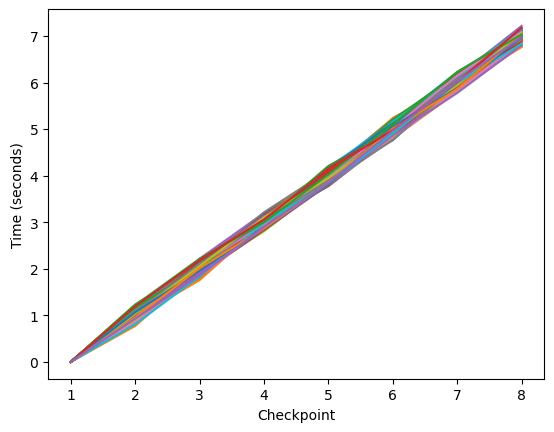

In [22]:
races = spark.sql("""
    SELECT 
        *, 
        FROM_UNIXTIME(start) 
    FROM 
        races
    WHERE 
        car_id == '584613543557'
""")

graph_races(races, legend=False)

## AI Queries

LLMs allow you to ask natural language questions of your data and have the question converted to queries that can be performed on your data. Here we will use Google Gemeni and Langchain

### Set up connection

Make sure the environment variable **GOOGLE_API_KEY** is set. You can get a key from the [AI studio](https://aistudio.google.com/app/apikey)

Create a Spark dataframe agent with the dataframe and LLM specified.

In [ ]:
from langchain_experimental.agents.agent_toolkits import create_spark_dataframe_agent
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro")

agent = create_spark_dataframe_agent(llm, df=df, verbose=True)

### Count the races for each car

In [ ]:
agent.invoke("Which car had the most races?")

### Graph the total times for each car

In [ ]:
agent.run("make a bar graph showing the average total time of each race per car id")

### Additional queries

In [ ]:
# agent.run("list the races where the car got to checkpoint_1 in under 5 seconds")

# agent.run("write me the sparksql to list the races where the car got to checkpoint_1 in under 5 seconds")

# agent.run("write me the code to list the races where the car got to checkpoint_1 in under 5 seconds")

# agent.run("make a pandas graph showing the races where the car got to checkpoint_1 in under 5 seconds")

## Write data to BigQuery

You can write your Spark data to BigQuery.

In [ ]:
race_count_by_car = spark.sql("""
    SELECT 
        car_id, 
        count(car_id) as count
    FROM
        races
    GROUP BY car_id
""")

race_count_by_car.write \
    .format("bigquery") \
    .option("writeMethod", "direct") \
    .mode("overwrite") \
    .save("data_dash.races") 